In [ ]:
import torch 
import time
import torch.nn as nn
from torch.optim import SGD
import matplotlib.pyplot as plt
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader

In [70]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

In [71]:
x = [[3,4], [4,2], [5,2], [6,8]]
y = [[3], [2], [3], [7]]

X = torch.tensor(x).float()
Y = torch.tensor(y).float()

## Simple Neural Net

In [72]:
class MyNet(nn.Module):
    def __init__(self):
        super().__init__() # inherit nn module
        # layers
        self.input_to_hidden = nn.Linear(in_features=2, out_features=7, bias=True) # two inputs, 7 outputs
        self.hidden_activation = nn.ReLU()
        self.hidden_to_output = nn.Linear(in_features=7, out_features=1, bias=True) # 7 inputs, 1 output
        '''The nn.Linear object is a callable module. When we call it like self.input_to_hidden(x), 
        we're invoking its __call__ method, which internally calls the forward method.'''
    
    # forward pass
    def forward(self, x):
        x = self.input_to_hidden(x)
        x = self.hidden_activation(x)
        x = self.hidden_to_output(x)
        return x
    
# reproduce values
torch.manual_seed(3)
mynet = MyNet()
# print('weights:\n', mynet.input_to_hidden.weight) # weights only
print('parameters:\n', list(mynet.parameters())) # weights and biases

parameters:
 [Parameter containing:
tensor([[-0.7011, -0.5578],
        [-0.3029, -0.6690],
        [-0.0401, -0.6221],
        [ 0.3845,  0.3446],
        [ 0.1335,  0.5485],
        [-0.0693,  0.4235],
        [-0.4952, -0.1393]], requires_grad=True), Parameter containing:
tensor([-0.6305, -0.0574, -0.4588,  0.6352,  0.4912,  0.5301,  0.2097],
       requires_grad=True), Parameter containing:
tensor([[-0.2156,  0.3396, -0.3688, -0.2412, -0.2361, -0.1567,  0.0754]],
       requires_grad=True), Parameter containing:
tensor([-0.2863], requires_grad=True)]


In [73]:
# # define neural net using nn.Parameter
# class MyNet2(nn.Module):
#     def __init__(self, *args, **kwargs):
#         super().__init__(*args, **kwargs)
#         self.input_to_hidden = nn.Parameter(torch.rand(2, 7))
#         self.hidden_activation = nn.ReLU()
#         self.hidden_to_output = nn.Parameter(torch.rand(8, 1))

#     # forward pass
#     def forward(self, x):
#         x = x @ self.input_to_hidden
#         x = self.hidden_activation(x)
#         x = x @ self.hidden_to_output
#         return x 

# # reproduce values
# torch.manual_seed(3)
# mynet = MyNet2()
# # print('weights:\n', mynet.input_to_hidden.weight) # weights only
# print('\nparameters:\n', list(mynet.parameters())) # weights and biases

In [74]:
loss_func = nn.MSELoss() # loss function, mean squared error
_Y = mynet(X) # predict 
loss_value = loss_func(_Y, Y) # calculate loss
print(loss_value) 

tensor(43.3236, grad_fn=<MseLossBackward0>)


In [75]:
loss_history = []
# optimizer 
opt = SGD(mynet.parameters(), lr=0.001)
for i in range(50):
    opt.zero_grad() # flush previous epochs grads
    loss_value = loss_func(mynet(X), Y) # calculate loss
    # back prop
    loss_value.backward()
    opt.step() # update weights
    # append current loss to loss history
    loss_history.append(loss_value.item())

In [76]:
print('initial epoch loss: ', loss_history[0])
print('final epoch loss: ', loss_history[-1])

initial epoch loss:  43.32361602783203
final epoch loss:  0.24372059106826782


Text(0.5, 1.0, 'Loss over increasing epochs')

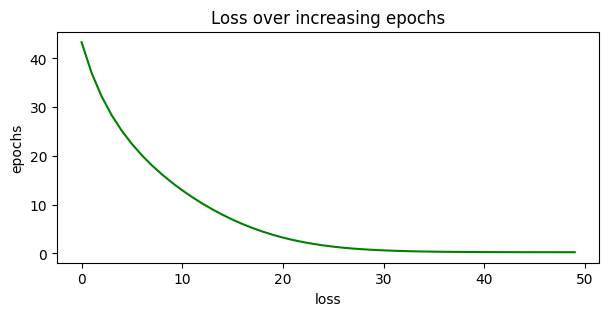

In [77]:
# plot loss history
plt.figure(figsize=(7, 3))
plt.plot(loss_history, color='green')
plt.xlabel('loss')
plt.ylabel('epochs')
plt.title('Loss over increasing epochs')

## Dataset, Dataset Loader, Bactch size

In [78]:
# custom dataset
x = [[3,4], [3,2], [5,1], [6,8]]
y = [[3], [2], [3], [7]]

X = torch.tensor(x).float()
Y = torch.tensor(y).float()

class MyDataset(Dataset):
    def __init__(self, x, y):
        super().__init__()
        self.x = torch.tensor(x).float()
        self.y = torch.tensor(y).float()
    
    def __len__(self):
        return len(self.x) # len of dataset
    
    def __getitem__(self, ix):
        return self.x[ix], self.y[ix] # get specific row of data

# instances
data_set = MyDataset(X, Y)
# dataloader
dl = DataLoader(data_set, batch_size=2, shuffle=True)
# print batches
i = 0
for x, y in dl:
    i += 1
    print(f'batch {i}:\n', x, y)

print('dataset length: ', data_set.__len__())
print('dataset row 0: ', data_set.__getitem__(0))
print('dataset row 1: ', data_set.__getitem__(1))
print('dataset row 2: ', data_set.__getitem__(2))
print('dataset row 3: ', data_set.__getitem__(3))
# print('dataset row 4: ', data_set.__getitem__(4)) out of bound , we have 4 rows

batch 1:
 tensor([[3., 4.],
        [5., 1.]]) tensor([[3.],
        [3.]])
batch 2:
 tensor([[3., 2.],
        [6., 8.]]) tensor([[2.],
        [7.]])
dataset length:  4
dataset row 0:  (tensor([3., 4.]), tensor([3.]))
dataset row 1:  (tensor([3., 2.]), tensor([2.]))
dataset row 2:  (tensor([5., 1.]), tensor([3.]))
dataset row 3:  (tensor([6., 8.]), tensor([7.]))


In [79]:
# neural net training with batches
class MyNeuralNet3(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.input_to_hidden = nn.Linear(2, 8)
        self.hidden_activation = nn.ReLU()
        self.hidden_to_output = nn.Linear(8, 1)
    def forward(self, x):
        x = self.input_to_hidden(x)
        x = self.hidden_activation(x)
        x = self.hidden_to_output(x)
        return x

# instance
mynet3 = MyNeuralNet3()
loss_func3 = nn.MSELoss()
opt = SGD(mynet3.parameters(), lr=0.01)
loss_history3 = []
start = time.time()
for i in range(50):
    for data in dl:
        # flush previous epochs grads
        opt.zero_grad()
        loss_value3 = loss_func3(mynet3(x), y)
        loss_value3.backward()
        opt.step() # update weights
        loss_history3.append(loss_value3.item())
end = time.time()
print(end - start)

0.3187377452850342


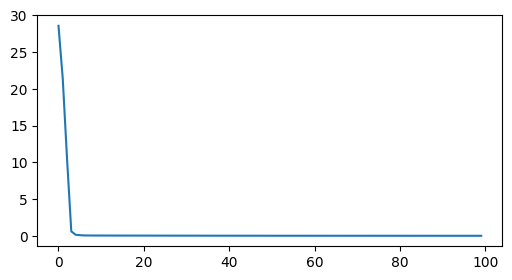

In [80]:
plt.figure(figsize=(6, 3))
plt.plot(loss_history3)

In [81]:
# predict new values
val_x = [[10, 15]]
val_x = torch.tensor(val_x).float()
mynet(val_x)

tensor([[11.2401]], grad_fn=<AddmmBackward0>)

## Custom Loss Functions

In [82]:
def mean_square_error(_y, y):
    loss = (_y - y) ** 2
    loss = loss.mean()
    return loss

In [83]:
# comparison with nn.MSELoss()
loss_func3 = nn.MSELoss()
loss_value = loss_func3(mynet3(X), Y)
print(loss_value)
mse_loss = mean_square_error(mynet3(X), Y)
print(mse_loss)

tensor(0.2796, grad_fn=<MseLossBackward0>)
tensor(0.2796, grad_fn=<MeanBackward0>)


## Fetching the values of intermediate layers

In [84]:
# parameters
print(mynet3.input_to_hidden)
print(mynet3.hidden_activation)
print(mynet3.hidden_to_output)

Linear(in_features=2, out_features=8, bias=True)
ReLU()
Linear(in_features=8, out_features=1, bias=True)


In [85]:
# method 1 for values
layer1 = mynet3.input_to_hidden(X)
layer2 = mynet3.hidden_activation(layer1)
layer3 = mynet3.hidden_to_output(layer2)
print(layer1)
print(layer2)
print(layer3)

tensor([[-3.7002, -1.4185, -3.7127,  4.1104, -0.0290, -0.4394, -2.2686, -1.1597],
        [-2.4745, -1.0469, -3.0506,  2.5593,  0.1378, -0.8619, -1.3017, -0.9621],
        [-3.1301, -1.5571, -4.1215,  2.5151,  0.0088, -2.2197, -1.1589, -1.2039],
        [-8.0543, -3.2056, -7.1399,  8.3099, -0.6812, -1.3141, -4.7135, -2.0657]],
       grad_fn=<AddmmBackward0>)
tensor([[0.0000, 0.0000, 0.0000, 4.1104, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 2.5593, 0.1378, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 2.5151, 0.0088, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 8.3099, 0.0000, 0.0000, 0.0000, 0.0000]],
       grad_fn=<ReluBackward0>)
tensor([[3.3828],
        [2.0554],
        [2.0159],
        [6.9814]], grad_fn=<AddmmBackward0>)


In [86]:
# method 2 for values
print(mynet3(X)[0])
print(mynet3(X)[1])
print(mynet3(X)[2])
print(mynet3(X)[3])

tensor([3.3828], grad_fn=<SelectBackward0>)
tensor([2.0554], grad_fn=<SelectBackward0>)
tensor([2.0159], grad_fn=<SelectBackward0>)
tensor([6.9814], grad_fn=<SelectBackward0>)


## Sequential Method

In [98]:
# load dataset
class MyDataset4(Dataset):
    def __init__(self, x, y):
        super().__init__()
        self.x = torch.tensor(x).float()
        self.y = torch.tensor(y).float()
    def __getitem__(self, ix):
        return self.x[ix], self.y[ix]
    def __len__(self):
        return len(self.x)
x = [[3,4], [3,2], [5,1], [6,8]]
y = [[3], [2], [3], [7]]
ds = MyDataset4(x, y)
dl = DataLoader(ds, batch_size=2, shuffle=True)

# build neural network
model = nn.Sequential(
    nn.Linear(in_features=2, out_features=8),
    nn.ReLU(),
    nn.Linear(in_features=8, out_features=1)
)

# print model summary
summary(model=model, input_size=(1,2))

# output shape -> [-1, 1, 8] 
# -1 -> batch size
# 1 -> number of samples
# 8 -> number of features

# params -> weights + biases = (in_features * out_features) + bias
# (2 * 8) + 8 = 24
# relu : no params
# (8 * 1) + 1 = 9

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 1, 8]              24
              ReLU-2                 [-1, 1, 8]               0
            Linear-3                 [-1, 1, 1]               9
Total params: 33
Trainable params: 33
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [116]:
# loss function
loss_func = nn.MSELoss()
# optimizer
opt = SGD(model.parameters(), lr=0.01)
# keep loss history
loss_history = []
# train model
start = time.time()
for i in range(100):
    for ix, iy in dl:
        # flush previous grads
        opt.zero_grad()
        # calculate loss
        loss_value = loss_func(model(ix), iy)
        # backprop
        loss_value.backward()
        # update weights
        opt.step()
        # append loss to loss history
        loss_history.append(loss_value.item())
end = time.time()
print(f'\n--training completed in: {end - start}--')


--training completed in: 0.45111680030822754--


Text(0, 0.5, 'loss')

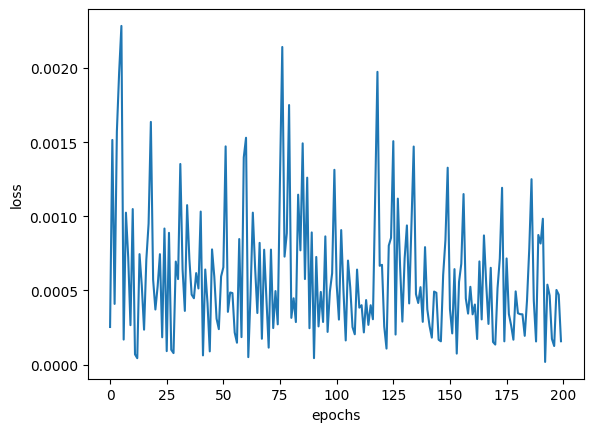

In [117]:
plt.plot(loss_history)
plt.xlabel('epochs')
plt.ylabel('loss')

In [118]:
# make predictions
val = [[8,9],[10,11],[1.5,2.5]]
model(torch.tensor(val).float())

tensor([[ 8.6963],
        [10.9275],
        [ 1.3158]], grad_fn=<AddmmBackward0>)

## Save and Load Model

In [122]:
# get current state of the trained model
model.state_dict()
# returns each layer's weights and bias, layer 0 and 2 in this context as layer 1 is relu with no weights

OrderedDict([('0.weight',
              tensor([[-0.5155,  0.2488],
                      [-0.5024, -0.0443],
                      [ 0.5218, -0.6542],
                      [ 0.2039,  0.6768],
                      [-0.0795, -0.0080],
                      [-0.4107, -0.2310],
                      [ 0.7208,  0.1007],
                      [-0.2697, -0.3755]])),
             ('0.bias',
              tensor([-0.6387, -0.6151, -0.0599, -0.3085,  0.5408, -0.5517, -0.2803,  0.0215])),
             ('2.weight',
              tensor([[-0.0828, -0.2070,  0.2175,  0.7122, -0.3211,  0.1226,  0.5945,  0.1049]])),
             ('2.bias', tensor([-0.3842]))])

In [123]:
# save the model
torch.save(model.state_dict(), 'mymodel.pth')

## Load Model

In [125]:
# requires first initializing model with random weights
model_new = nn.Sequential(
  nn.Linear(2, 8), 
  nn.ReLU(),
  nn.Linear(8, 1)
 )

In [127]:
# load the model
state_dict = torch.load('mymodel.pth')
print(state_dict)

OrderedDict({'0.weight': tensor([[-0.5155,  0.2488],
        [-0.5024, -0.0443],
        [ 0.5218, -0.6542],
        [ 0.2039,  0.6768],
        [-0.0795, -0.0080],
        [-0.4107, -0.2310],
        [ 0.7208,  0.1007],
        [-0.2697, -0.3755]]), '0.bias': tensor([-0.6387, -0.6151, -0.0599, -0.3085,  0.5408, -0.5517, -0.2803,  0.0215]), '2.weight': tensor([[-0.0828, -0.2070,  0.2175,  0.7122, -0.3211,  0.1226,  0.5945,  0.1049]]), '2.bias': tensor([-0.3842])})


In [129]:
# add these state to randomly initialized model
model.load_state_dict(state_dict)
# make predictions
model(torch.tensor(val).float())

tensor([[ 8.6963],
        [10.9275],
        [ 1.3158]], grad_fn=<AddmmBackward0>)